# Plotting Tiles

## Objectives

Introduce several different methods for plotting ECCO v4 fields that are stored as tiles in `Datasets` or `DataArrays`.  Emphasis is placed on fields stored on the ECCO v4 native llc90 grid and loaded from NetCDF tile files.

## Introduction

*"Over the years many different plotting modules and packages have been developed for Python. For most of that time there was no clear favorite package, but recently matplotlib has become the most widely used. Nevertheless, many of the others are still available and may suit your tastes or needs better. Some of these are interfaces to existing plotting libraries while others are Python-centered new implementations.*
-- from : https://wiki.python.org/moin/NumericAndScientific/Plotting


The link above profiles a long list of Python tools for plotting.  In this tutorial we use just two libraries, *matplotlib* and *basemap*.

### matplotlib
*"Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shell, the jupyter notebook, web application servers, and four graphical user interface toolkits."*

*"For simple plotting the pyplot module provides a MATLAB-like interface, particularly when combined with IPython. For the power user, you have full control of line styles, font properties, axes properties, etc, via an object oriented interface or via a set of functions familiar to MATLAB users."*
-- from https://matplotlib.org/index.html

Matplotlib and pyplot even have a tutorial: https://matplotlib.org/users/pyplot_tutorial.html

### Basemap

*"The matplotlib basemap toolkit is a library for plotting 2D data on maps in Python. It is similar in functionality to the matlab mapping toolbox, the IDL mapping facilities, GrADS, or the Generic Mapping Tools."*
-- from https://matplotlib.org/basemap/users/intro.html#cartopy-new-management-and-eol-announcement

For much more information about basemap, including a detailed tutorial see: http://basemaptutorial.readthedocs.io/en/latest/index.html


## The default orientation of the lat-lon-cap tile fields

Before we begin plotting ECCO v4 fields on the native llc grid we should refresh our memory about their relative orientation with respect to each other and with respect to $x$ and $y$.

![llc90 tile layout](../figures/llc90.png "The orientation of the 13 llc tiles")

Tiles 8-13 are rotated 90 degrees counter-clockwise relative to tiles 1-6.

> **Note:**  *This orientation can be challenging to deal with at first but don't panic!  We'll introduce routines to reorient these tiles so that they line up with tiles 1-6 in the next tutorial!  The good news is that you don't need to reorient tiles to plot them.*

## Plotting fields from one tile

First, let's load the all 13 tiles for sea surface height and the model grid parameters.

In [1]:
import numpy as np
from copy import deepcopy 
import xarray as xr
import sys
import matplotlib.pylab as plt
import numpy as np
import warnings
from mpl_toolkits.basemap import Basemap
warnings.filterwarnings('ignore')

%matplotlib inline
sys.path.append('/Users/ifenty/git_repo_mine/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# specify the location of your nctiles_monthly directory
data_dir='/Volumes/ECCO_BASE/ECCO_v4r3/nctiles_monthly/SSH/'    
var = 'SSH'
var_type = 'c'
ssh_all_tiles = ecco.load_all_tiles_from_netcdf(data_dir, var, var_type, less_output=True)

# specify the location of your nctiles_grid directory
grid_dir='/Volumes/ECCO_BASE/ECCO_v4r3/nctiles_grid/'
var = 'GRID'
var_type = 'grid'
grid_all_tiles = ecco.load_all_tiles_from_netcdf(grid_dir, var, var_type, less_output=True)

# Merge the SSH and GRID Datasets together into one `v4` Dataset
v4 = xr.merge([ssh_all_tiles, grid_all_tiles])

Finished loading all 13 tiles of SSH
Finished loading all 13 tiles of GRID


### Plotting a single tile with imshow

First we'll plot the average SSH for the first month (Jan 1992) on tiles 3, 7, and 8 using the basic `imshow` routine from *pyplot*.  We are plotting these three different tiles to show that these lat-lon-cap tiles all have a different orientation in $x$ and $y$.

> **Note:** *The **origin='lower'** argument to `imshow` is required to make the $y$ origin at the bottom of the plot.*

#### Tile 3 (Northeast N. Atlantic)

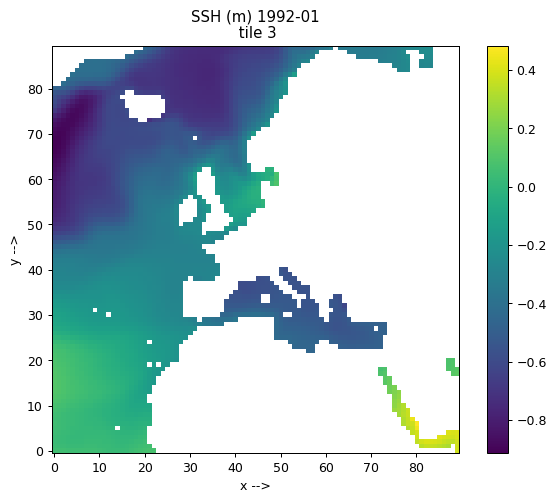

In [3]:
plt.figure(figsize=(8,6), dpi= 90)

# Step 1, select the tile to plot using the **.sel( )** syntax.  
tile_to_plot = v4.SSH.sel(tile=3, time=1)

# Step 2, use plt.imshow() 
plt.imshow(tile_to_plot, origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 3')
plt.xlabel('x -->')
plt.ylabel('y -->')
# Step 4, send the show() command to show the plot.
plt.show()

Tiles 1-6 are by default in a quasi-lat-lon orientation.  +$x$ is to the east and +$y$ is to the north.

#### Tile 7 (the Arctic cap)

This time we'll plot the Arctic cap tile 7.  Notice the layout of the Arctic cap tile in $x$ and $y$.  We'll follow the same procedure for plotting except we'll use LaTeX to add arrows in the $x$ and $y$ axis labels (for fun).

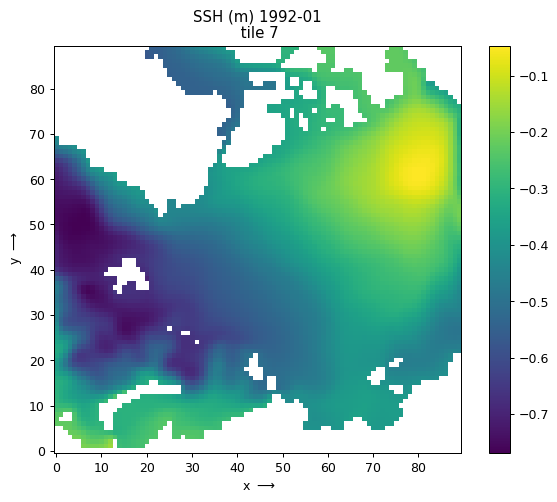

In [4]:
plt.figure(figsize=(8,6), dpi= 90)

tile_to_plot = v4.SSH.sel(tile=7, time=1)
plt.imshow(tile_to_plot, origin='lower');
plt.colorbar()
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 7')
# use the LaTeX interpreter in the x and y axis labels.  
# To interpret strings with LaTeX, use r' instead of '
plt.xlabel(r' x $\longrightarrow$')
plt.ylabel(r' y $\longrightarrow$')
plt.show()

Because tile 7 is the Arctic cap, $x$ and $y$ do not map to east and west throughout the domain.

#### Tile 8 (N. Pacific / Bering Sea / Chukchi Sea)

For tiles 8-13, positive $x$ is southwards and positive $y$ is eastwards.


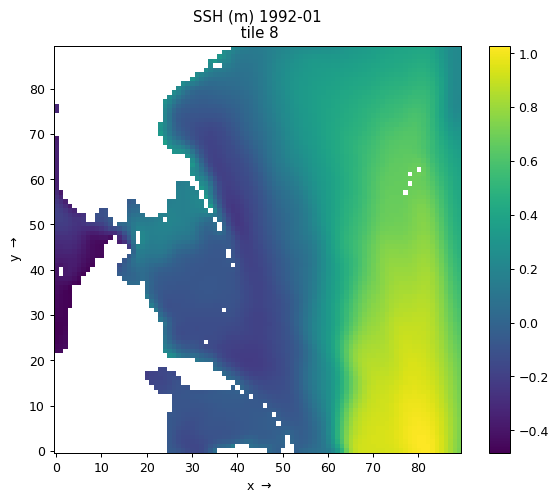

In [5]:
plt.figure(figsize=(8,6), dpi= 90)

tile_to_plot = v4.SSH.sel(tile=8, time=1)
plt.imshow(tile_to_plot, origin='lower');
plt.colorbar()
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 8')
plt.xlabel(r" x $\rightarrow$")
plt.ylabel(r" y $\rightarrow$")
plt.show()

Tiles 8-13 are are also in a quasi-lat-lon orientation except that +$x$ is to the south and +$y$ is to the east.

### Plotting a single tile with pcolor and contourf

The `pcolor` and `contourf` routines allows us to add latitude and longitude to the figure.  Because SSH is a 'c' point variable, its lat/lon coordinates are in ``XC``/``YC`` or ``lon_c``/``lat_c``.  Let's use ``lon_c`` and ``lat_c``.

We won't plot the Arctic cap because of the singularity at the pole and the 360 wrapping in longitude.  

`contourf` will be demonstrated for tile 8.

#### Tile 3 (Northeast N. Atlantic)

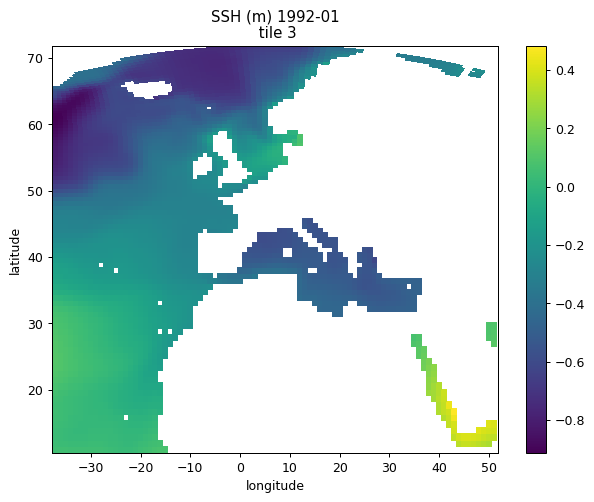

In [6]:
plt.figure(figsize=(8,6), dpi= 90)

# select tile 3's lats and l
lons = v4.lon_c.sel(tile=3)
lats = v4.lat_c.sel(tile=3)
tile_to_plot = v4.SSH.sel(tile=3, time=1)
plt.pcolor(lons, lats, tile_to_plot)
plt.colorbar()
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 3')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

#### Tile 8 (N. Pacific / Bering Sea / Chukchi Sea)

`pcolor` and `contourf` will orient fields geographically because it uses latitude and longitude as the x and y coordinates.

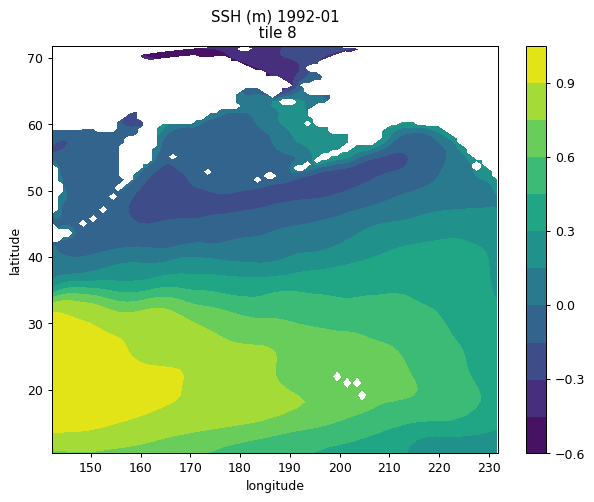

In [7]:
plt.figure(figsize=(8,6), dpi= 90)

lons = v4.lon_c.sel(tile=8)
lats = v4.lat_c.sel(tile=8)

# we must convert the longitude coordinates from 
# [-180 to 180] to [0 to 360] 
# because of the crossing of the international date line.
lons_tmp = np.copy(lons)
lons_tmp[lons_tmp < 0] = lons_tmp[lons_tmp < 0]+360

tile_to_plot = v4.SSH.sel(tile=8, time=1)

# the fourth argument to contourf (30) is the number of different color levels to use
plt.contourf(lons_tmp, lats, tile_to_plot, 10)

plt.colorbar()
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 8')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

### Plotting a single tile with basemap

The *basemap* package provides routines to make plots using different geographic projections.  We'll demonstrate plotting these three tiles again using *basemap*.

#### Tile 3 (Northeast N. Atlantic)

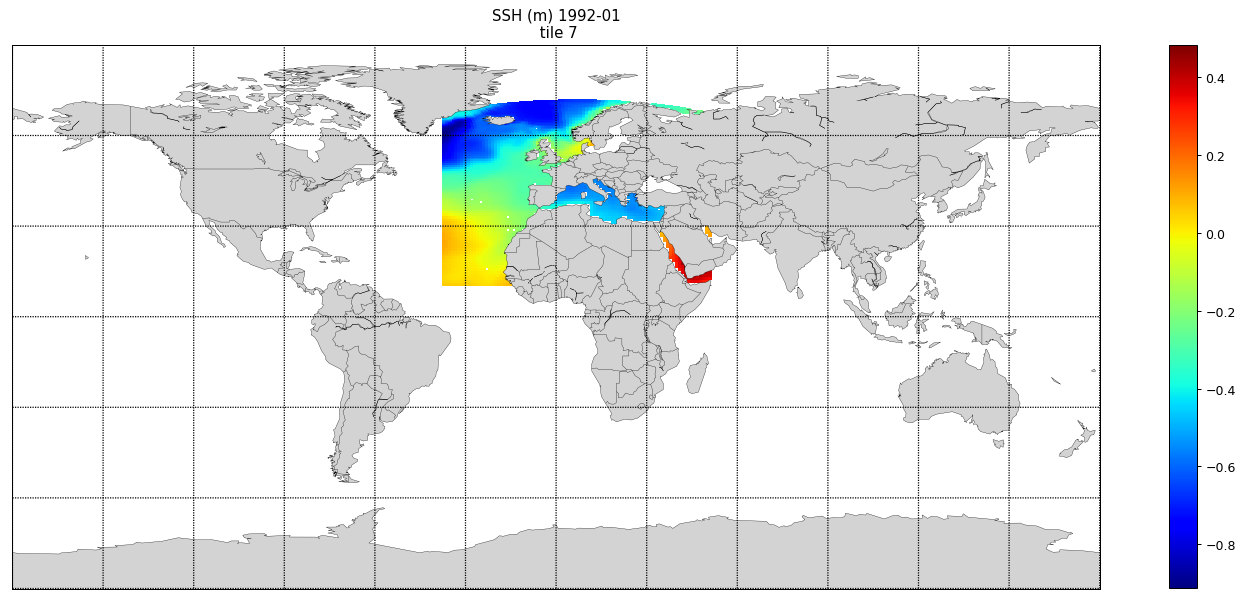

In [8]:
plt.figure(figsize=(20,8), dpi= 90)

lons = v4.XC.sel(tile=3)
lats = v4.YC.sel(tile=3)
tile_to_plot = v4.SSH.sel(tile=3, time=1)

# create a map with a cylindrical projection
map = Basemap(projection='cyl')

# project the longitude and latitudes to x and y
# pass the numpy arrays out of the lon/lon DataArrays
x,y = map(lons.values, lats.values)

# draw coastlines, country boundaries
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)

# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# give the continents and lakes the same color
map.fillcontinents(color='lightgray',lake_color='lightgray')

# use basemap pcolor
ax = map.pcolor(x,y, tile_to_plot ,cmap='jet')

# add colorbar and title
plt.colorbar()
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 7');

Beautiful.

#### Tile 7 (the Arctic cap)

Now we'll use a polar stereographic projection to show the Arctic Cap tile.  Just to show that it can be done, we'll also use `contourf` with 20 levels.

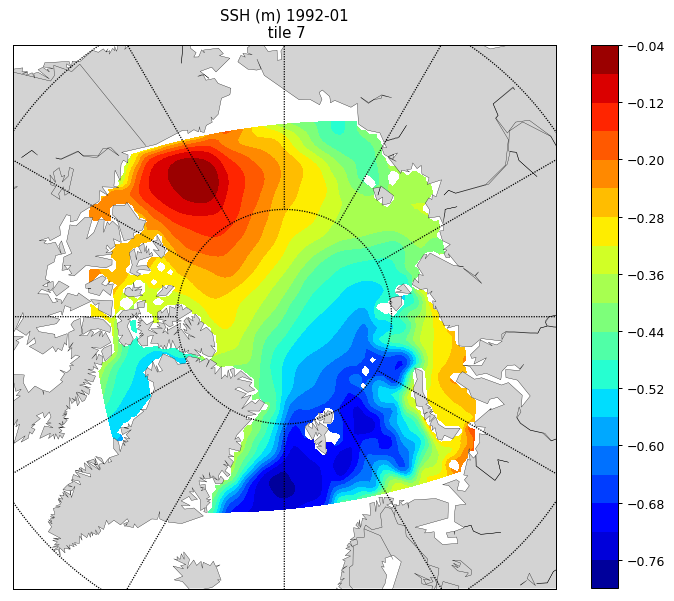

In [9]:
plt.figure(figsize=(10,8), dpi= 90)

lons = v4.XC.sel(tile=7)
lats = v4.YC.sel(tile=7)
tile_to_plot = v4.SSH.sel(tile=7, time=1)

# create a map with a north polar stereographic projection
# -- set the southernmost latitude to be 65N and orient so 
#    that 0E is at the bottom center.
map = Basemap(projection='npstere', boundinglat=65,lon_0=0)

# project lons and lats to x and y.
x,y = map(lons.values, lats.values)

# draw coastlines, country boundaries
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)

# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# give the continents and lakes the same color
map.fillcontinents(color='lightgray',lake_color='lightgray')

# use basemap's contourf routine with 20 levels
ax = map.contourf(x,y, tile_to_plot, 20, cmap='jet')

# add colorbar and title
plt.colorbar(shrink=1)
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 7');

Very Fancy.

#### Tile 8 (N. Pacific / Bering Sea / Chukchi Sea)

Finally we plot Tile 8 using a mercator projection, zoomed into close to the geographical bounds of the tile.  Again because of the crossing of the international date line, we convert the longitudes from [-180 to 180] to [0 360].  Here we also show how to add labels for our meridians and parallels.

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

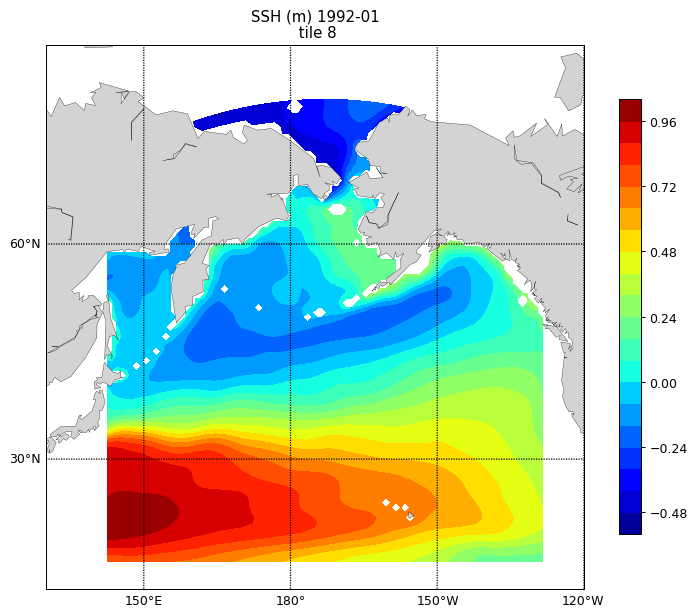

In [10]:
plt.figure(figsize=(10,8), dpi= 90)

lons = v4.XC.sel(tile=8).values
lats = v4.YC.sel(tile=8).values
tile_to_plot = v4.SSH.sel(tile=8, time=1)

# we must convert the longitude coordinates from 
# [-180 to 180] to [0 to 360] 
# because of the crossing of the international date line.

# an alternative way of doing this is to use the `unwrap` function of numpy
# https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.unwrap.html
lons_360 = np.rad2deg(np.unwrap(np.deg2rad(lons), axis=0))

# define the new map with mercator projection
# lower-left corner longitude  = 130
# lower-left corner latitude   = 5
# upper-right corner longitude = 240
# upper-right corner latitude  = 75
map = Basemap(llcrnrlon=130, llcrnrlat=5,urcrnrlon=240.,urcrnrlat=75.,
              projection='merc')

# project lons and lats to x and y.
#x,y = map(lons_tmp, lats.values)
x,y = map(lons_360, lats)

# draw coastlines
map.drawcoastlines(linewidth=0.25)

# draw lat/lon grid lines every 30 degrees.
meridians = np.arange(0,360,30)
parallels = np.arange(-90,90,30)

# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,True,False])
map.drawmeridians(meridians,labels=[True,False,False,True])

# give the continents and lakes the same color
map.fillcontinents(color='lightgray',lake_color='lightgray')

# use basemap's contourf routine with 20 levels
ax = map.contourf(x,y, tile_to_plot, 20, cmap='jet')

# add colorbar and title
plt.colorbar(shrink=.8)
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7] + '\n tile 8');

As you can see in the above, the northern part of tile 8 curves poleward.  Indeed, a poleward curving is found in all tiles adjacent to tile 7 (3, 6, 8 and 11).  To demonstrate we'll plot the boundaries of every 5th model grid cell in tile 8.

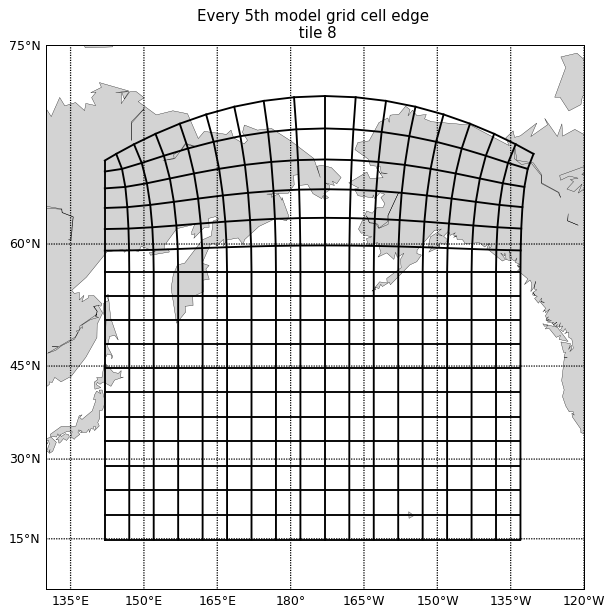

In [11]:
plt.figure(figsize=(10,8), dpi= 90)

# Use XG and YG because those are the coordinates of grid cell corners
# unlike XC and YC which are the coordinates of grid cell centers
lons = v4.XG.sel(tile=8).values
lats = v4.YG.sel(tile=8).values

lons_360 = np.rad2deg(np.unwrap(np.deg2rad(lons), axis=0))

# project lons and lats to x and y.
x,y = map(lons_360, lats)

# draw coastlines
map.drawcoastlines(linewidth=0.25)

# draw lat/lon grid lines every 30 degrees.
meridians = np.arange(0,360,15)
parallels = np.arange(-90,90,15)
map.drawparallels(parallels,labels=[True,False,True,False])
map.drawmeridians(meridians,labels=[True,False,False,True])
map.fillcontinents(color='lightgray',lake_color='lightgray')

# use basemap's plot command to show the edges of every 5th grid cell
ax = map.plot(x[0::5,0::5],y[0::5,0::5],'k')
# --- the .T command is the transpose operation for numpy arrays.
ax = map.plot(x[0::5,0::5].T, y[0::5,0::5].T,'k')

# add colorbar and title
plt.title('Every 5th model grid cell edge \n tile 8');

Grid cells in the southern part of the domain are aligned with parallels and meridians.  Deviations become apparent starting from just below 60N.  We'll explore the model grid in more detail in a later tutorial.

## Plotting fields from all 13 tiles simultaneously

### Plotting all 13 tiles with `plot_tiles`

#### lat-lon-cap layout
The custom `plot_tiles` routines in the ecco_v4_py package plot all 13 tiles of a field.  By default the routine will plot all of the tiles in the lat-lon-cap layout. The optional argument *cbar* tells the routine to add a colobar.  The optional arguments *cmin* and *cmax* specify the min and max values for the colorbar.

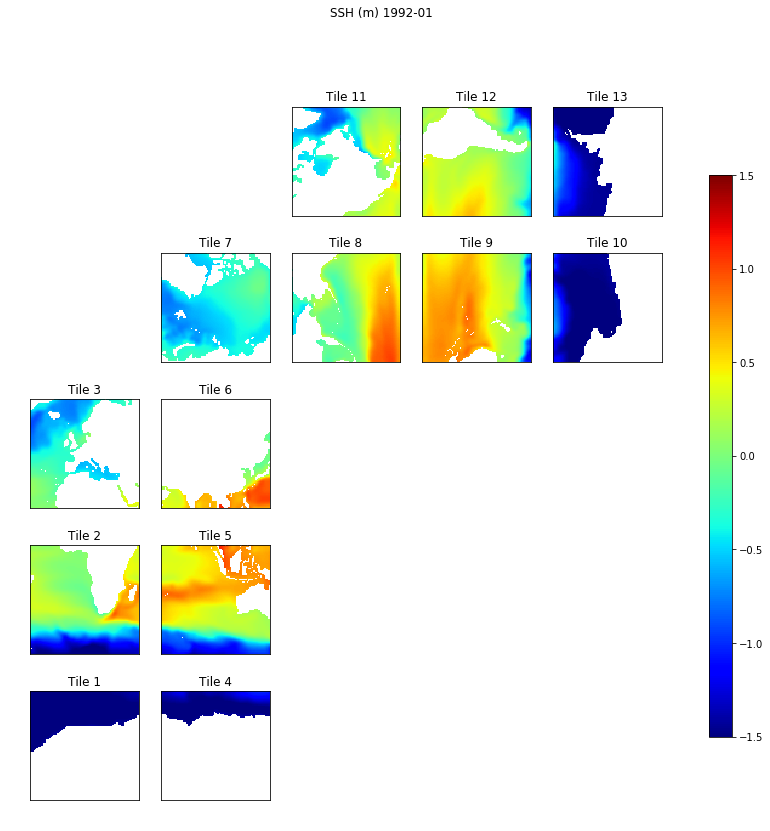

In [12]:
tiles = v4.SSH.sel(time=1)

# optional arguments:
#   cbar       - show the colorbar
#   cmin, cmax - color range min and max
#   fsize      - figure size in inches
ecco.plot_tiles(tiles, cbar=True, cmin=-1.5, cmax=1.5, fsize=13)

# use `suptitle` (super title) to make a title over subplots.
plt.suptitle('SSH (m) ' + str(v4.tim[0].values)[0:7]);

#### lat-lon layout

Another option of `plot_tiles` is to show tiles 8-13 rotated and lined up tiles 1-6.

> **Note:** *Rotation of tiles 8-13 is only for **plotting**.  These arrays are not rotated using this routine.  We'll show to how actually rotate these tiles in the next tutorial.*

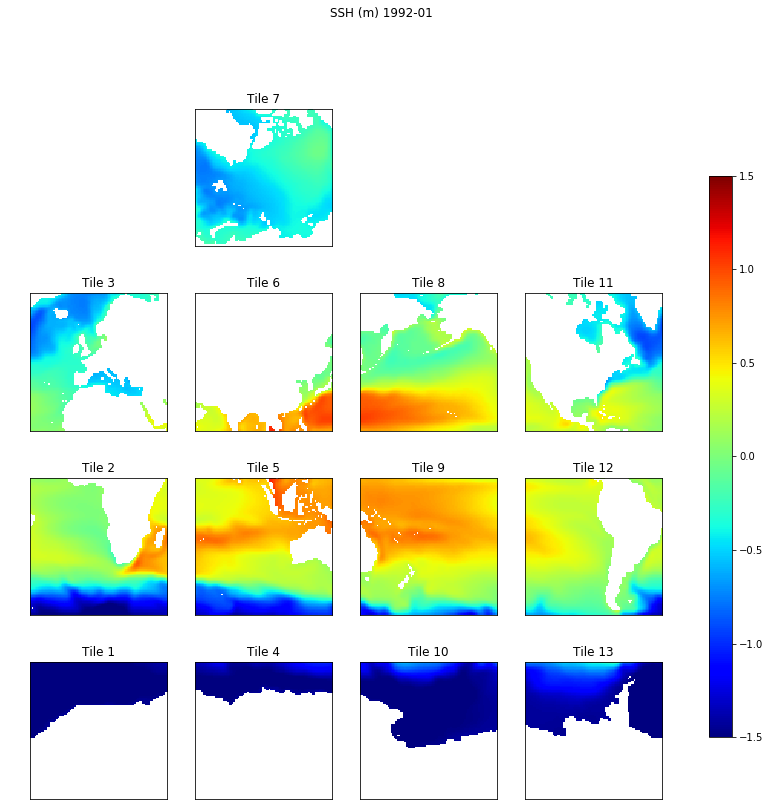

In [13]:
tiles = v4.SSH.sel(time=1)

# new optional argument:
# layout  -  either 'llc' or 'latlon'  default is 'llc
ecco.plot_tiles(tiles, cbar=True, cmin=-1.5, cmax=1.5, layout='latlon', fsize=13)

plt.suptitle('SSH (m) ' + str(v4.tim[0].values)[0:7]);

The last version of `plot_tiles` is to remove the tile labels and put the titles together in a tight formation:

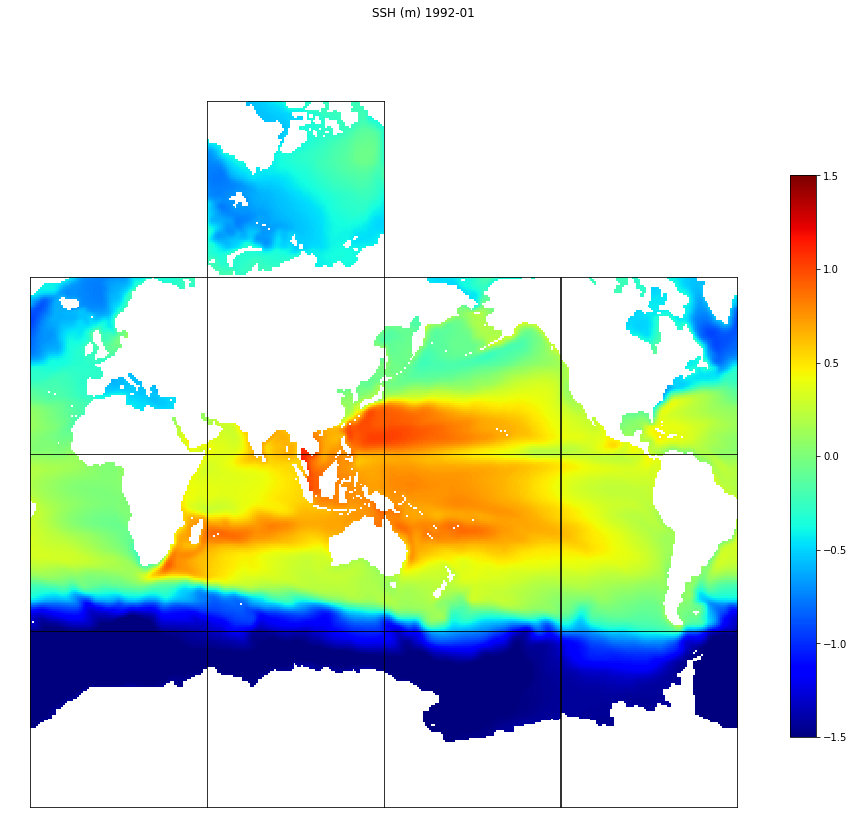

In [14]:
tiles = v4.SSH.sel(time=1)

ecco.plot_tiles(tiles, cbar=True, cmin=-1.5, cmax=1.5, 
                   layout='latlon', tile_labels=False, fsize=13)

plt.suptitle('SSH (m) ' + str(v4.tim[0].values)[0:7]);

*Almost ready for the hyperwall!*

### Plotting all 13 tiles with `plot_tiles_proj`

Our routine `plot_tiles_proj` takes `numpy` arrays or `DataArrays` with 13 tiles and creates global plots with one of three types of projections:

1. Robinson
2. Cylindrical
3. Polar Stereographic (north or south)

Other projections are of course possible.  Read up on how *basemap* works and customizing the routine for yourself!  

Before plotting this routine interpolates the original fields onto a 1/4 x 1/4 degree lat-lon grid to conform with the requirement of *basemap* that the fields be in lat-lon orientation.

There are only three argument required of `plot_tiles_proj`, an array of longitudes, an array of latitudes, and an array of the field you wish to plot.  The arrays can be either numpy arrays or `DataArrays`.  

> **Note:** *To learn about the many optional arguments of `plot_tiles_proj` you can documentation of the 
the `plot_tiles_proj` routine in the **ecco_v4_py.plot_tile** module provided in the **ECCO v4 Python code** section of the tutorial.*

#### Robinson projection
First we'll show the Robinson projection.  The default left most meridian is 0E (projection centered at 180E)

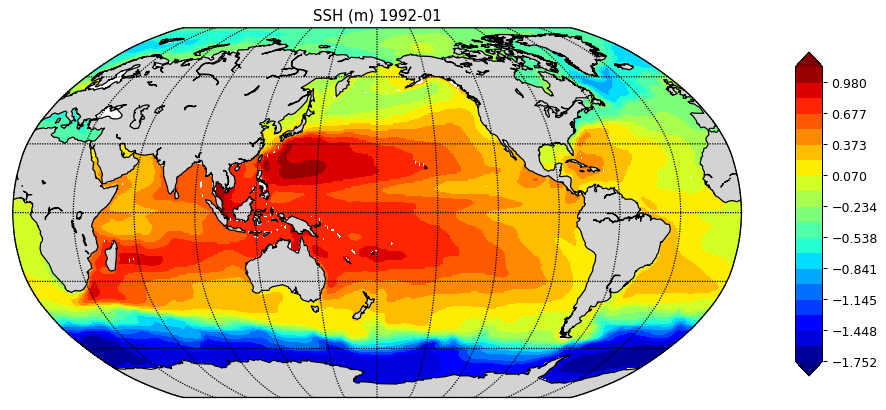

In [15]:
plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_tiles_proj(v4.XC, 
                     v4.YC,
                     v4.SSH.sel(time=1),
                     cbar=True,
                     plot_type = 'contourf',
                     projection_type = 'robin')
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7]);

Setting *lon_0* = 115E yields a global centering that is particularly well liked in the oceanographic community:

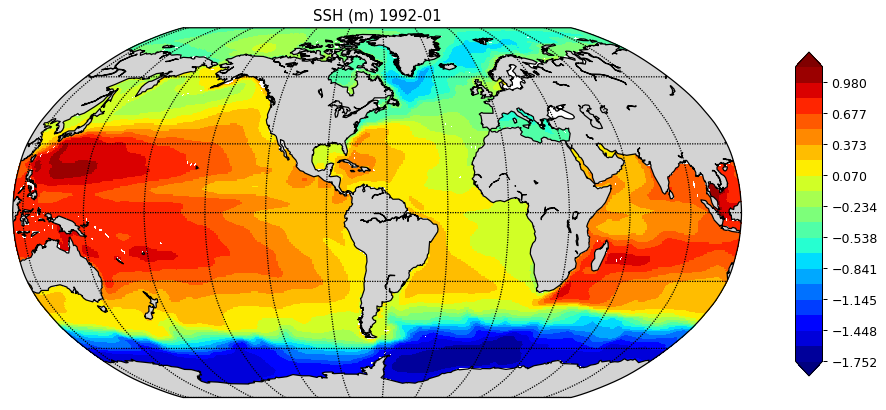

In [16]:
plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_tiles_proj(v4.XC, v4.YC, v4.SSH.sel(time=1),
                     cbar=True,
                     plot_type = 'contourf',
                     projection_type = 'robin',
                     lon_0 = 115)
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7]);

#### Cylindrical projection

Besides setting the projection to cylindrical, you also have the option to use *pcolor*.  The leftmost meridian can also be changed with lon_0 (default = 0E).  For some reason pcolor is much slower than contourf.

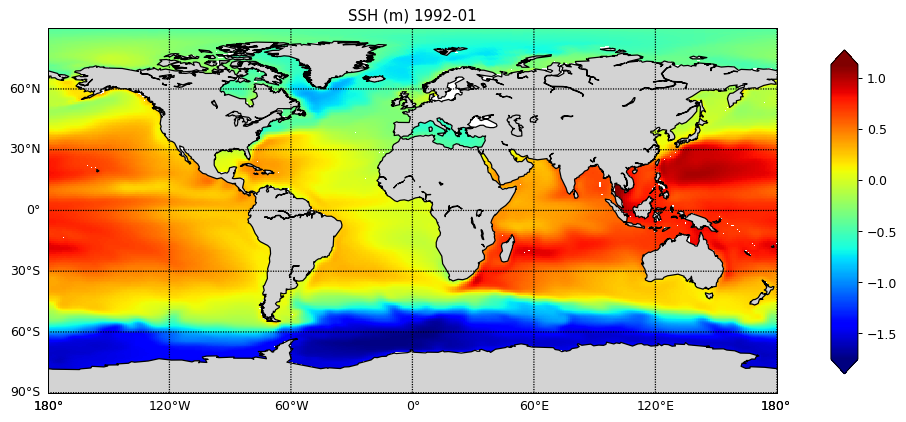

In [17]:
plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_tiles_proj(v4.XC, 
                     v4.YC,
                     v4.SSH.sel(time=1),
                     cbar=True,
                     plot_type = 'pcolor',
                     projection_type = 'cyl', lon_0=180)
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7]);

#### Polar stereographic projection

The final projection built into `plot_tiles_proj` is polar stereographic.  The argument *bounding_lat* determines the limit of the projection.  If *bounding_lat* is postive, the projection is centered around the north pole and vice versa.

##### Northern Hemisphere

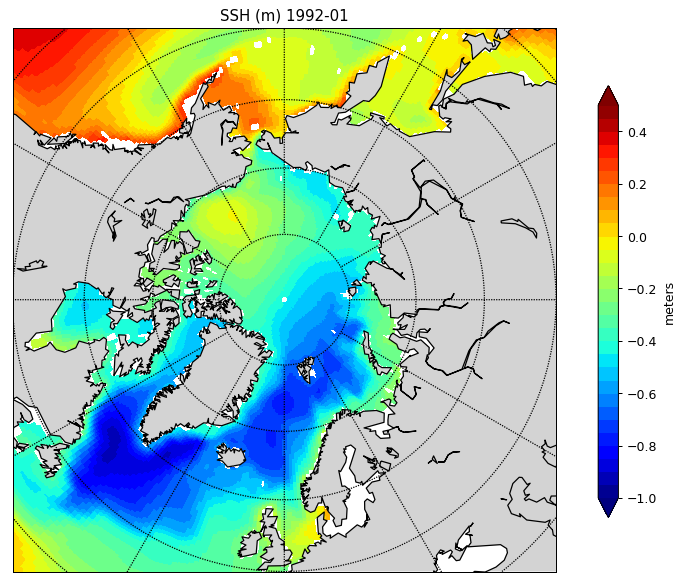

In [18]:
plt.figure(figsize=(9,8),dpi=90)

# contourf colors can be controlled using the following bit of code
# which bounds the color range (my_cmin to my_cmax) and provides a 
# color step size (my_cint)
my_cmin =-1.; my_cmax=.5;  my_cint=.05
# this calculates the number of levels between my_cmin and my_cmax 
# with my_cint step sizes
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

# here we also pass a label to the colorbar, extra fancy.  
f=ecco.plot_tiles_proj(v4.XC, 
                   v4.YC,
                   v4.SSH.sel(time=1),
                   cbar=True,
                   plot_type = 'contourf', lon_0=0,
                   projection_type = 'stereo',bounding_lat=50,
                   cbar_label='meters',
                   num_levels = my_num_levels,
                   cmin = my_cmin,
                   cmax = my_cmax)
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7]);

##### Southern Hemisphere

The final example is a south-pole centered plot.  Note that *bounding_lat* is now negative and we've changed the lon_0 to be 180E (a very common preference).

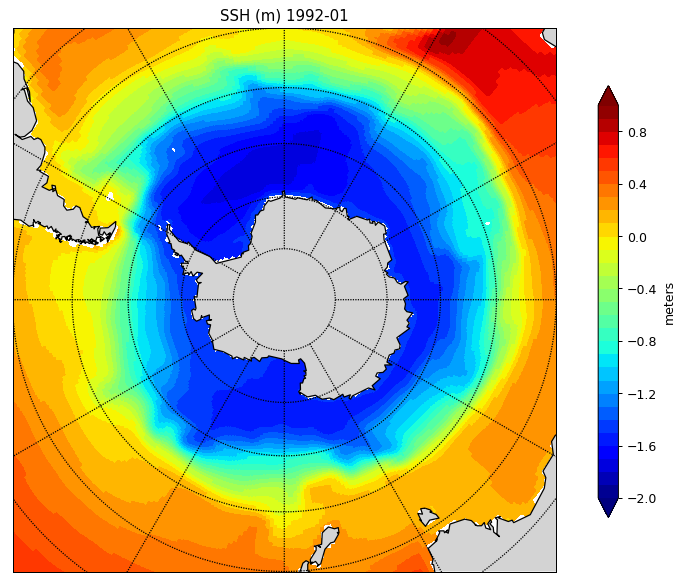

In [19]:
plt.figure(figsize=(9,8),dpi=90)

my_cmin =-2.; my_cmax=1;  my_cint=.1
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

# here we also pass a label to the colorbar, extra fancy.  
f=ecco.plot_tiles_proj(v4.XC, 
                   v4.YC,
                   v4.SSH.sel(time=1),
                   cbar=True,
                   plot_type = 'contourf', lon_0=180,
                   projection_type = 'stereo',bounding_lat=-40,
                   cbar_label='meters',
                   num_levels = my_num_levels,
                   cmin = my_cmin,
                   cmax = my_cmax)
plt.title('SSH (m) ' + str(v4.tim[0].values)[0:7]);

## Conclusion

You now know several ways of plotting ECCO state estimate fields.